# fsspec
https://filesystem-spec.readthedocs.io/en/latest/features.html#caching-files-locally

In [1]:
import fsspec
import xarray as xr
from dask.utils import format_bytes
import os

In [91]:
from dask.distributed import Client
client = Client(processes=False, threads_per_worker=48, n_workers=1, memory_limit="64GB")
client

<Client: 'inproc://10.50.37.128/46610/229' processes=1 threads=48, memory=64.00 GB>

In [3]:
fs = fsspec.filesystem('sftp', host='xtape.dkrz.de',username='m300524',password='')

In [4]:
remote_path = '/hpss/arch/mj0060/m220053/experiments/vga0214/outdata/mpiom'

In [5]:
format_bytes(fs.du(remote_path))

'9.31 TB'

In [23]:
fs.ls(remote_path)[-10:]

['/hpss/arch/mj0060/m220053/experiments/vga0214/outdata/mpiom/vga0214_mpiom_data_3d_ym_3400-3499.nc',
 '/hpss/arch/mj0060/m220053/experiments/vga0214/outdata/mpiom/vga0214_mpiom_data_3d_ym_3500-3599.nc',
 '/hpss/arch/mj0060/m220053/experiments/vga0214/outdata/mpiom/vga0214_mpiom_data_3d_ym_3600-3699.nc',
 '/hpss/arch/mj0060/m220053/experiments/vga0214/outdata/mpiom/vga0214_mpiom_data_3d_ym_3700-3799.nc',
 '/hpss/arch/mj0060/m220053/experiments/vga0214/outdata/mpiom/vga0214_mpiom_data_3d_ym_3800-3819.nc',
 '/hpss/arch/mj0060/m220053/experiments/vga0214/outdata/mpiom/vga0214_mpiom_data_moc_mm_1850-3819.nc',
 '/hpss/arch/mj0060/m220053/experiments/vga0214/outdata/mpiom/vga0214_mpiom_fx_18500101_18501231.nc',
 '/hpss/arch/mj0060/m220053/experiments/vga0214/outdata/mpiom/vga0214_mpiom_map_18500101_18501231.nc',
 '/hpss/arch/mj0060/m220053/experiments/vga0214/outdata/mpiom/vga0214_mpiom_monitoring_ym_1850-3819.nc',
 '/hpss/arch/mj0060/m220053/experiments/vga0214/outdata/mpiom/vga0214_mpiom_t

# direct file access from mistral

## monitoring

In [72]:
file=fs.ls(remote_path)[-1]
file

'/hpss/arch/mj0060/m220053/experiments/vga0214/outdata/mpiom/vga0214_mpiom_timeser_mm_1850-3819.nc'

In [73]:
format_bytes(fs.du(file))

'21.34 MB'

In [74]:
%%time
with fs.open(file) as f:
    ds = xr.open_dataset(f, chunks={}, use_cftime=True)

ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending coro=<RequestHandler._execute() running at /work/mh0727/m300524/miniconda3/envs/pymistral/lib/python3.7/site-packages/tornado/web.py:1703> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x2ad29597a190>()]> cb=[_HandlerDelegate.execute.<locals>.<lambda>() at /work/mh0727/m300524/miniconda3/envs/pymistral/lib/python3.7/site-packages/tornado/web.py:2333]>
ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending coro=<RequestHandler._execute() running at /work/mh0727/m300524/miniconda3/envs/pymistral/lib/python3.7/site-packages/tornado/web.py:1703> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x2ad3166cbdd0>()]> cb=[_HandlerDelegate.execute.<locals>.<lambda>() at /work/mh0727/m300524/miniconda3/envs/pymistral/lib/python3.7/site-packages/tornado/web.py:2333]>
ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending coro=<RequestHandler._execute() running at /

CPU times: user 19.5 s, sys: 2.07 s, total: 21.5 s
Wall time: 22.9 s


CPU times: user 1.54 s, sys: 286 ms, total: 1.82 s
Wall time: 3.33 s


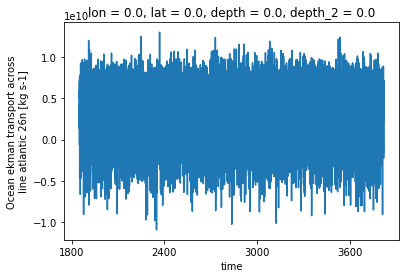

In [75]:
%%time
ds.squeeze()['ekmantransport_atlantic_26n'].plot()

## data file

In [82]:
file=fs.ls(remote_path)[1]
file

'/hpss/arch/mj0060/m220053/experiments/vga0214/outdata/mpiom/vga0214_mpiom_data_2d_3h_1860-1869.nc'

In [83]:
format_bytes(fs.du(file))

'6.59 GB'

In [ ]:
%%time
with fs.open(file) as f:
    ds = xr.open_mfdataset(f, chunks={'time':240}, use_cftime=True, parallel=True)

# copy files to mistral

In [92]:
file = '/hpss/arch/mj0060/m220053/experiments/vga0214/vga0214_scripts.tar'
format_bytes(fs.du(file))

'544.03 MB'

In [93]:
%%time
new_file = 'vga0214_scripts.tar'
fs.get(file, new_file)

CPU times: user 21.5 s, sys: 3.72 s, total: 25.2 s
Wall time: 21.4 s


In [94]:
os.remove(new_file)

In [95]:
print('throughput: ',544/20, 'MB/sec')

throughput:  27.2 MB/sec


# large file

In [96]:
file = fs.ls(remote_path)[10] # [200]
print(format_bytes(fs.du(file)))
file

6.59 GB


'/hpss/arch/mj0060/m220053/experiments/vga0214/outdata/mpiom/vga0214_mpiom_data_2d_3h_1950-1959.nc'

In [97]:
%%time
new_file = 'tempfile'
fs.get(file, new_file)

CPU times: user 4min 15s, sys: 45.4 s, total: 5min
Wall time: 4min 16s


In [98]:
os.remove(new_file)

In [21]:
print(f'throughput: {13180/(11*60+38)} MB/sec for file {file}')

throughput: 18.882521489971346 MB/sec for file /hpss/arch/mj0060/m220053/experiments/vga0214/outdata/mpiom/vga0214_mpiom_data_2d_dm_1880-1889.nc


In [15]:
print(f'throughput: {6590/(4*60+34)} MB/sec for file {file}')

throughput: 24.05109489051095 MB/sec for file /hpss/arch/mj0060/m220053/experiments/vga0214/outdata/mpiom/vga0214_mpiom_data_2d_3h_1950-1959.nc


# walk

In [71]:
[i for i in fs.walk('/hpss/arch/mj0060/m220053/experiments/vga0214', maxdepth=3)]

[('/hpss/arch/mj0060/m220053/experiments/vga0214',
  ['outdata', 'restart'],
  ['vga0214_bin.tar',
   'vga0214_outdata_land.tar',
   'vga0214_scripts.tar',
   'vga0214_log.tar']),
 ('/hpss/arch/mj0060/m220053/experiments/vga0214/outdata',
  ['echam6', 'jsbach', 'mpiom', 'hamocc'],
  []),
 ('/hpss/arch/mj0060/m220053/experiments/vga0214/outdata/echam6',
  [],
  ['vga0214_echam6_echam_2400-2499.grb',
   'vga0214_echam6_ATM_mm_2400-2499.grb',
   'vga0214_echam6_echam_2500-2599.grb',
   'vga0214_echam6_ATM_mm_2500-2599.grb',
   'vga0214_echam6_BOT_mm_1850-1999.grb',
   'vga0214_echam6_LOG_mm_1850-1999.grb',
   'vga0214_echam6_BOT_mm_2000-2999.grb',
   'vga0214_echam6_LOG_mm_2000-2999.grb',
   'vga0214_echam6_BOT_mm_3000-3819.grb',
   'vga0214_echam6_LOG_mm_3000-3819.grb',
   'vga0214_echam6_echam_1850-1899.grb',
   'vga0214_echam6_ATM_mm_1850-1899.grb',
   'vga0214_echam6_echam_1900-1999.grb',
   'vga0214_echam6_ATM_mm_1900-1999.grb',
   'vga0214_echam6_echam_2000-2099.grb',
   'vga0214_ec